In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Paso 1: Cargar la base de datos
data = pd.read_csv('resultado.csv')
sequences = data['Seqence'].tolist()
labels = data['Activity'].tolist()

# Transformar las etiquetas en formato binario
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform([label.split(',') for label in labels])

# Paso 2: Preparar el dataset personalizado
class PeptideDataset(Dataset):
    def __init__(self, sequences, labels, max_length=100):
        self.sequences = sequences
        self.labels = labels
        self.max_length = max_length
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.encoder.fit(np.array([list("ACDEFGHIKLMNPQRSTVWY")]).T)  # One-hot encoding de los aminoácidos

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = list(self.sequences[idx])
        if len(sequence) < self.max_length:
            sequence += ['X'] * (self.max_length - len(sequence))
        else:
            sequence = sequence[:self.max_length]

        sequence = np.array(sequence).reshape(-1, 1)
        sequence_encoded = self.encoder.transform(sequence)
        sequence_encoded = torch.tensor(sequence_encoded, dtype=torch.float32)

        # Convertir la etiqueta a tensor (vector binario)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)  # Cambiar a float para multilabel
        return sequence_encoded, label

# Paso 3: División de datos en conjunto de entrenamiento y validación
train_sequences, val_sequences, train_labels, val_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)
train_dataset = PeptideDataset(train_sequences, train_labels)
val_dataset = PeptideDataset(val_sequences, val_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Paso 4: Definir el modelo CNN
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes, max_length=100):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=20, out_channels=64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7, padding=3)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Calcular el tamaño de la salida de las capas convolucionales
        dummy_input = torch.zeros(1, 20, max_length)
        dummy_output = self._forward_features(dummy_input)
        flattened_size = dummy_output.shape[1] * dummy_output.shape[2]

        # Capas completamente conectadas
        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def _forward_features(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        return x

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Cambiar la dimensión para Conv1d
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)  # Aplanar
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Paso 5: Configurar el modelo, la función de pérdida y el optimizador
num_classes = labels.shape[1]  # Número de clases únicas en el conjunto de datos
model = ImprovedCNN(num_classes)
criterion = nn.BCEWithLogitsLoss()  # Cambiar la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.001)

# Paso 6: Definir funciones de entrenamiento y evaluación
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    for sequences, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for sequences, labels in dataloader:
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Aplicar una umbralización para convertir logits en predicciones
            predicted = (torch.sigmoid(outputs) > 0.5).float()  # Ajusta el umbral según sea necesario
            correct += (predicted == labels).sum().item()
    accuracy = correct / (len(dataloader.dataset) * labels.shape[1])  # Normalizar por número de clases
    return total_loss / len(dataloader), accuracy

# Paso 7: Entrenamiento del modelo
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer)
    val_loss, val_accuracy = evaluate(model, val_dataloader, criterion)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

Epoch 1/50, Training Loss: 0.6921
Validation Loss: 0.6888, Accuracy: 0.5366
Epoch 2/50, Training Loss: 0.6848
Validation Loss: 0.6788, Accuracy: 0.6297
Epoch 3/50, Training Loss: 0.6681
Validation Loss: 0.6522, Accuracy: 0.7787
Epoch 4/50, Training Loss: 0.6156
Validation Loss: 0.5713, Accuracy: 0.8879
Epoch 5/50, Training Loss: 0.4886
Validation Loss: 0.4136, Accuracy: 0.9462
Epoch 6/50, Training Loss: 0.3210
Validation Loss: 0.2738, Accuracy: 0.9462
Epoch 7/50, Training Loss: 0.2200
Validation Loss: 0.2096, Accuracy: 0.9462
Epoch 8/50, Training Loss: 0.1777
Validation Loss: 0.1834, Accuracy: 0.9462
Epoch 9/50, Training Loss: 0.1624
Validation Loss: 0.1713, Accuracy: 0.9462
Epoch 10/50, Training Loss: 0.1553
Validation Loss: 0.1648, Accuracy: 0.9462
Epoch 11/50, Training Loss: 0.1508
Validation Loss: 0.1608, Accuracy: 0.9462
Epoch 12/50, Training Loss: 0.1488
Validation Loss: 0.1583, Accuracy: 0.9462
Epoch 13/50, Training Loss: 0.1465
Validation Loss: 0.1563, Accuracy: 0.9462
Epoch 14

Epoch 1/50, Training Loss: 0.1301
Validation Loss: 0.1405, Accuracy: 0.9462
Epoch 2/50, Training Loss: 0.1289
Validation Loss: 0.1404, Accuracy: 0.9462
Epoch 3/50, Training Loss: 0.1284
Validation Loss: 0.1402, Accuracy: 0.9462
Epoch 4/50, Training Loss: 0.1281
Validation Loss: 0.1401, Accuracy: 0.9462
Epoch 5/50, Training Loss: 0.1279
Validation Loss: 0.1398, Accuracy: 0.9463
Epoch 6/50, Training Loss: 0.1273
Validation Loss: 0.1398, Accuracy: 0.9463
Epoch 7/50, Training Loss: 0.1276
Validation Loss: 0.1396, Accuracy: 0.9463
Epoch 8/50, Training Loss: 0.1272
Validation Loss: 0.1394, Accuracy: 0.9474
Epoch 9/50, Training Loss: 0.1280
Validation Loss: 0.1392, Accuracy: 0.9479
Epoch 10/50, Training Loss: 0.1273
Validation Loss: 0.1391, Accuracy: 0.9479
Epoch 11/50, Training Loss: 0.1277
Validation Loss: 0.1388, Accuracy: 0.9490
Epoch 12/50, Training Loss: 0.1269
Validation Loss: 0.1388, Accuracy: 0.9487
Epoch 13/50, Training Loss: 0.1267
Validation Loss: 0.1386, Accuracy: 0.9490
Epoch 14

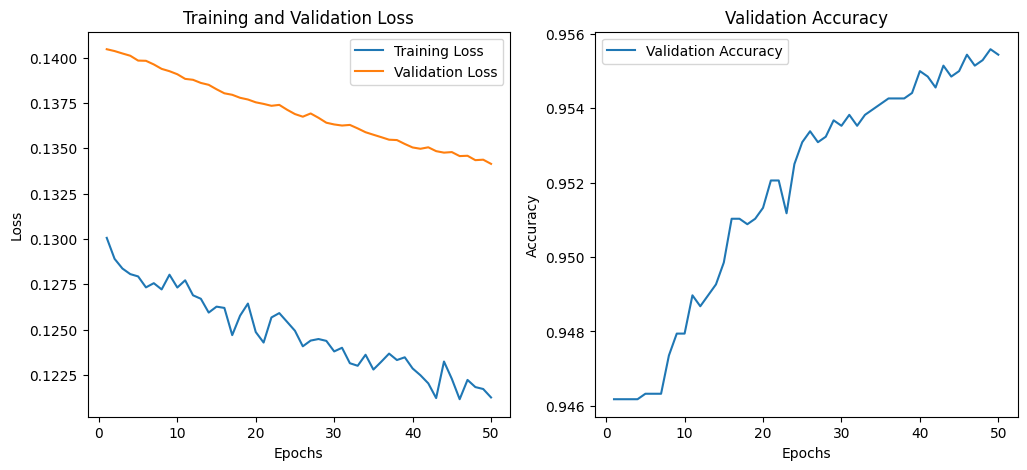

In [9]:
import matplotlib.pyplot as plt

# Inicializa listas para almacenar pérdidas y precisiones
train_losses = []
val_losses = []
val_accuracies = []

# Paso 7: Entrenamiento del modelo con almacenamiento de métricas
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer)
    val_loss, val_accuracy = evaluate(model, val_dataloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

# Graficar la pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Graficar la precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()

In [17]:
# Paso 7: Entrenamiento del modelo
num_epochs = 50
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer)
    val_loss, val_accuracy = evaluate(model, val_dataloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

# Paso 8: Graficar las métricas
plt.figure(figsize=(12, 5))

# Graficar la pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Graficar la precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()

# Paso 9: Función para predecir propiedades antimicrobianas
def predict(model, sequence, encoder, mlb):
    model.eval()
    with torch.no_grad():
        sequence = list(sequence)
        # Padding o recorte de la secuencia al máximo largo especificado
        if len(sequence) < 100:
            sequence += ['X'] * (100 - len(sequence))
        else:
            sequence = sequence[:100]

        sequence = np.array(sequence).reshape(-1, 1)
        sequence_encoded = encoder.transform(sequence)  # Utilizar el encoder pasado como argumento
        sequence_encoded = torch.tensor(sequence_encoded, dtype=torch.float32).unsqueeze(0)  # Agregar dimensión de batch

        outputs = model(sequence_encoded)
        predicted = torch.sigmoid(outputs) > 0.5  # Umbralizar para obtener predicciones binarias
    return predicted

# Ejemplo de uso para hacer predicciones
example_sequence = 'AELRCMCIKTTSGIHPKNIQSLEVIGKGTHCNQVEVIATLKDGRKICLDPDAPRIKKIVQKKLAGD'
predicted_properties = predict(model, example_sequence, train_dataset.encoder, mlb)  # Pasar el encoder y el mlb

# Imprimir las predicciones
print("Predicted properties (binary):", predicted_properties.numpy())
print("Predicted properties (classes):", mlb.inverse_transform(predicted_properties.numpy()))

# Paso 10: Guardar el modelo
torch.save(model.state_dict(), 'modelo_cnn.pth')

# Para cargar el modelo posteriormente
loaded_model = ImprovedCNN(num_classes)
loaded_model.load_state_dict(torch.load('modelo_cnn.pth'))
loaded_model.eval()  # Establecer en modo evaluación

Epoch 1/50, Training Loss: 0.1305
Validation Loss: 0.1401, Accuracy: 0.9462
Epoch 2/50, Training Loss: 0.1289
Validation Loss: 0.1400, Accuracy: 0.9462
Epoch 3/50, Training Loss: 0.1286
Validation Loss: 0.1399, Accuracy: 0.9463


KeyboardInterrupt: 

In [16]:
# Ejemplo de uso para hacer predicciones
example_sequence2 = 'GEWYNQTKDLQQKFYEIIMDIEQNNVQGKKGIQQL'
predicted_properties = predict(model, example_sequence2, train_dataset.encoder, mlb)  # Pasar el encoder y el mlb

# Imprimir las predicciones
print("Predicted properties (binary):", predicted_properties.numpy())
print("Predicted properties (classes):", mlb.inverse_transform(predicted_properties.numpy()))

Predicted properties (binary): [[False False False False False False False False False False  True False
  False False False False False]]
Predicted properties (classes): [('Antibacterial',)]
